# Stat 159 Final Project - Predicting Spotify Track Popularity from Audio Features

**Group 22**

## Abstract
We study whether a track’s quantitative audio features from Spotify (e.g., danceability, energy, loudness, acousticness, valence) can predict Spotify’s popularity score (0–100). After cleaning and sampling, our analysis uses 114,000 tracks. Popularity is broadly distributed (mean 33.24, median 35, IQR [17, 50]). Multiple linear regression provides an interpretable baseline, and we compare it against Ridge and LASSO regularization. All three linear models perform similarly; the best test RMSE is 20.03 popularity points. Correlations between individual audio features and popularity are weak. Multicollinearity is present but modest (largest VIF among predictors is 4.26 for energy). Overall, audio features capture some signal but leave substantial variation unexplained, motivating richer nonlinear models and/or additional contextual covariates.


## 1. Introduction
Spotify provides a popularity score intended to summarize a track’s overall consumption and engagement on the platform. A natural question is whether we can explain, or even predict this popularity using only the track’s audio features derived from Spotify’s Web API.

**Research question:** 

*Can we predict a song’s Spotify popularity score from quantitative audio features such as danceability, energy, loudness, acousticness, and valence?*  
We focus on an interpretable baseline: multiple linear regression, with Ridge/LASSO as comparisons.

## 2. Data
We use the Spotify Tracks Dataset from Kaggle, curated from the Spotify Web API and spanning tracks from 1921–2020. The dataset includes numerical audio descriptors (e.g., danceability, energy, loudness, tempo, valence) and the target variable `popularity`.

### Data handling and reproducibility
- Raw and cleaned Spofity dataset CSVs are stored under `data/`.
- EDA plots are written to `figures/`.
- Modeling outputs (summary tables, diagnostics, correlation matrix) are written to `results/`.

Because large raw datasets can be inconvenient to version-control directly, our workflow emphasizes reproducible scripts + exported results rather than rerunning heavy computations inside this notebook.


In [21]:
from pathlib import Path
import pandas as pd
import numpy as np
from IPython.display import Image, display, Markdown

ROOT = Path(".")
FIG_DIR = ROOT / "figures"
RES_DIR = ROOT / "results"

def show_fig(filename: str, caption: str, width: int = 900):
    path = FIG_DIR / filename
    if not path.exists():
        display(Markdown(f"**Missing figure:** `{path}`"))
        return
    display(Image(filename=str(path), width=width))
    display(Markdown(f"*Figure: {caption}*"))

def load_csv(filename: str) -> pd.DataFrame:
    path = RES_DIR / filename
    if not path.exists():
        raise FileNotFoundError(f"Missing required file: {path}")
    return pd.read_csv(path)


## 3. Exploratory Data Analysis
We begin by inspecting the distribution of popularity and core audio features. These plots summarize the cleaned/sampled dataset and help us anticipate modeling challenges (e.g., skew, heavy tails, or concentration near boundary values like 0 or 1).

In [24]:
popularity_summary = load_csv("popularity_summary.csv")

# If the stats are stored as an unnamed index column, convert it to 'stat'
if "stat" in popularity_summary.columns:
    popularity_summary = popularity_summary.set_index("stat")
elif "Unnamed: 0" in popularity_summary.columns:
    popularity_summary = popularity_summary.rename(columns={"Unnamed: 0": "stat"}).set_index("stat")
else:
    # fallback: assume the first column contains the stat names
    popularity_summary = popularity_summary.set_index(popularity_summary.columns[0])

# Clean any remaining unnamed columns
popularity_summary = popularity_summary.loc[:, ~popularity_summary.columns.str.startswith("Unnamed")]

# Make the value column name consistent
if "popularity" in popularity_summary.columns:
    popularity_summary = popularity_summary.rename(columns={"popularity": "value"})

display(popularity_summary)


,value
stat,
count,114000.000000
mean,33.238535
std,22.305078
min,0.000000
25%,17.000000
50%,35.000000
75%,50.000000
max,100.000000


The popularity score ranges from 0 to 100, with mean 33.24 and median 35. The middle 50% of tracks lie between 17 and 50, indicating substantial spread in popularity.

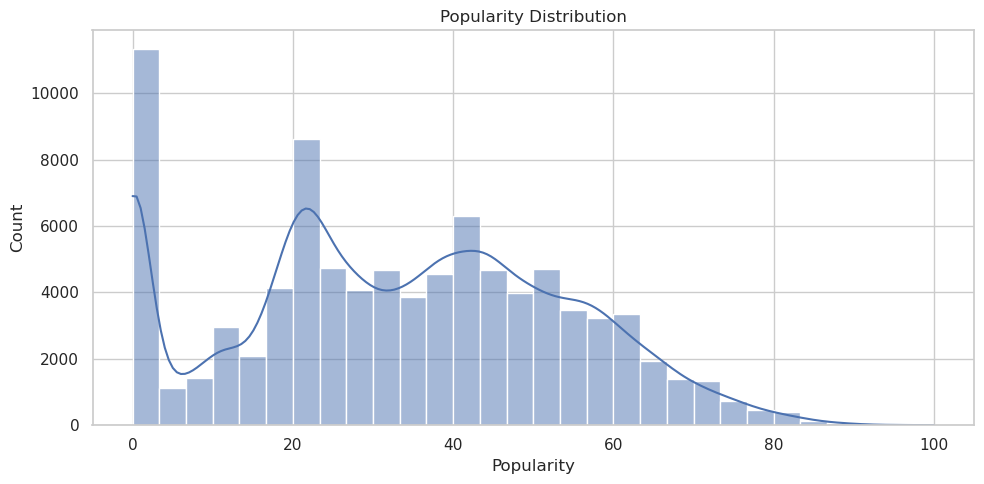

*Figure: Distribution of Spotify popularity. The distribution is wide, with substantial mass at low popularity and a long right tail toward highly popular tracks.*

In [25]:
show_fig("popularity_distribution.png", "Distribution of Spotify popularity. The distribution is wide, with substantial mass at low popularity and a long right tail toward highly popular tracks.")

### Audio feature distributions
Below are histograms for several audio features used in our models.

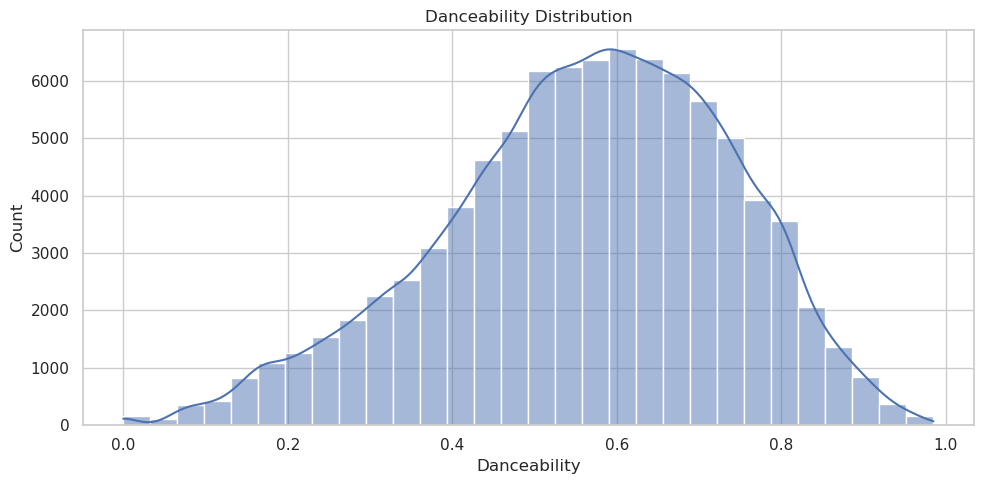

*Figure: Danceability is approximately unimodal, with many tracks concentrated around mid-to-high values.*

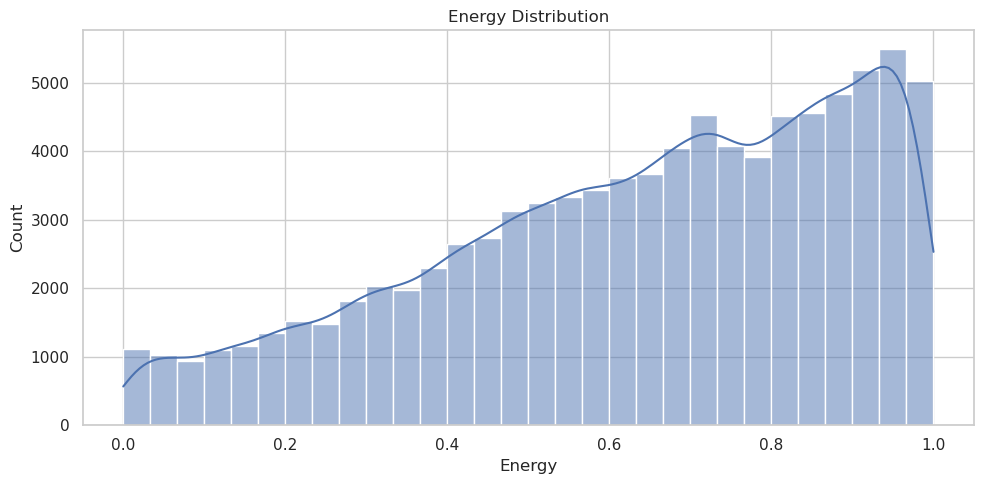

*Figure: Energy skews high: many tracks in the cleaned sample have relatively high energy.*

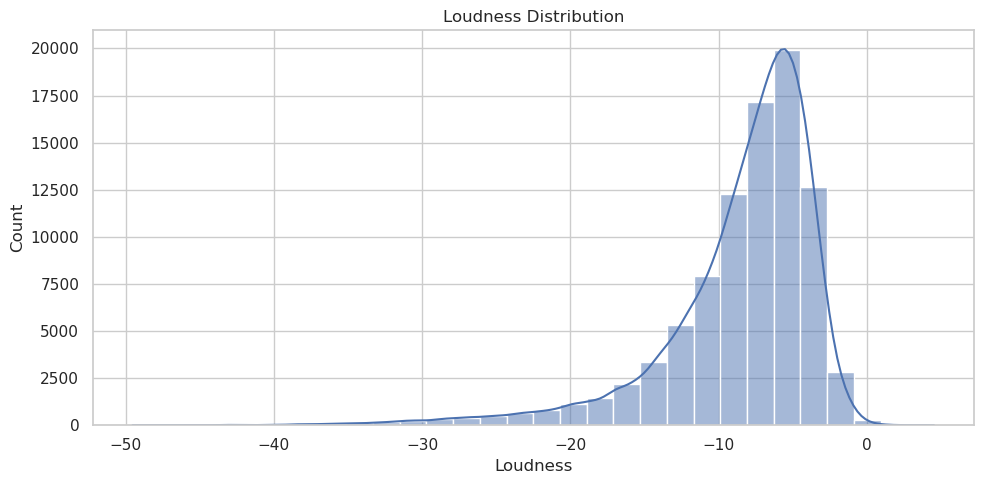

*Figure: Loudness (dB) is concentrated around a typical modern loudness range with a long left tail to very quiet tracks.*

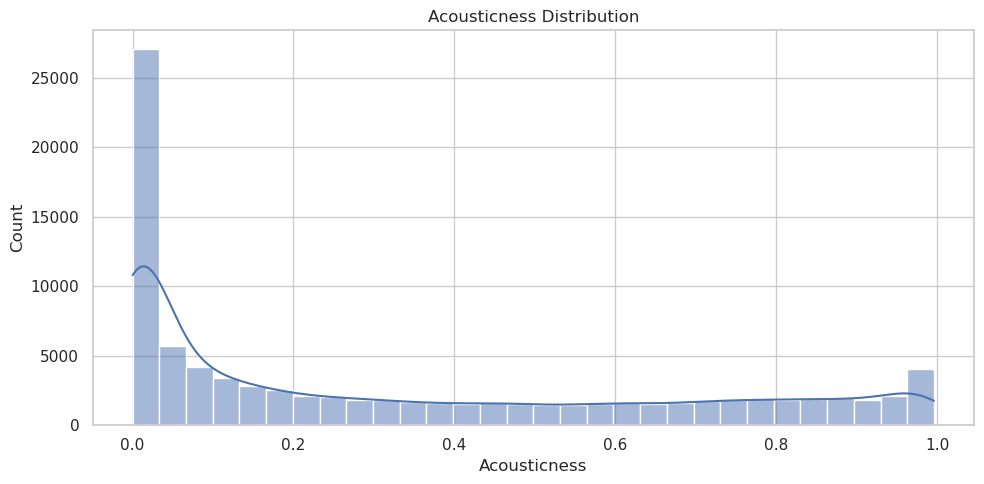

*Figure: Acousticness shows strong concentration near 0 (non-acoustic tracks), with a secondary mass toward higher acousticness.*

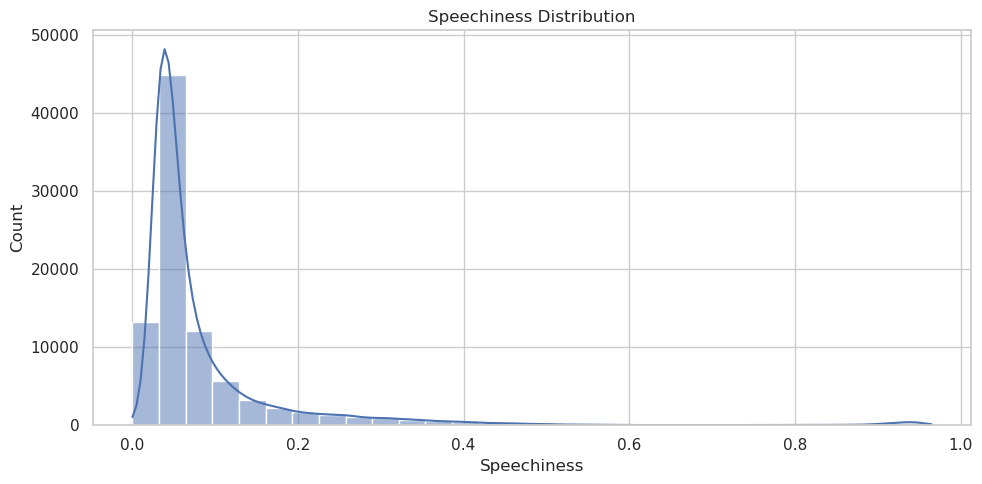

*Figure: Speechiness is strongly right-skewed, with most tracks near 0 and a small fraction with high speech content.*

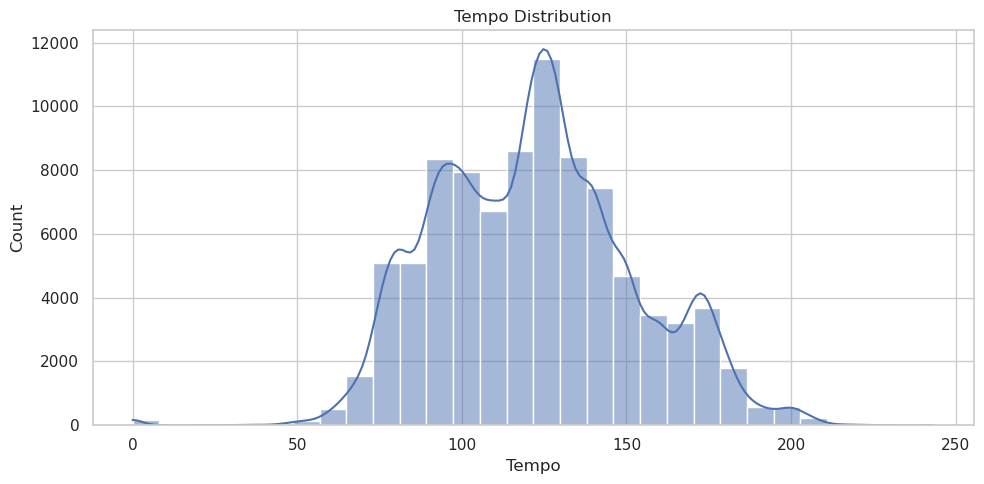

*Figure: Tempo is multi-modal, with common tempos around typical pop/rock ranges and additional smaller modes at higher tempos.*

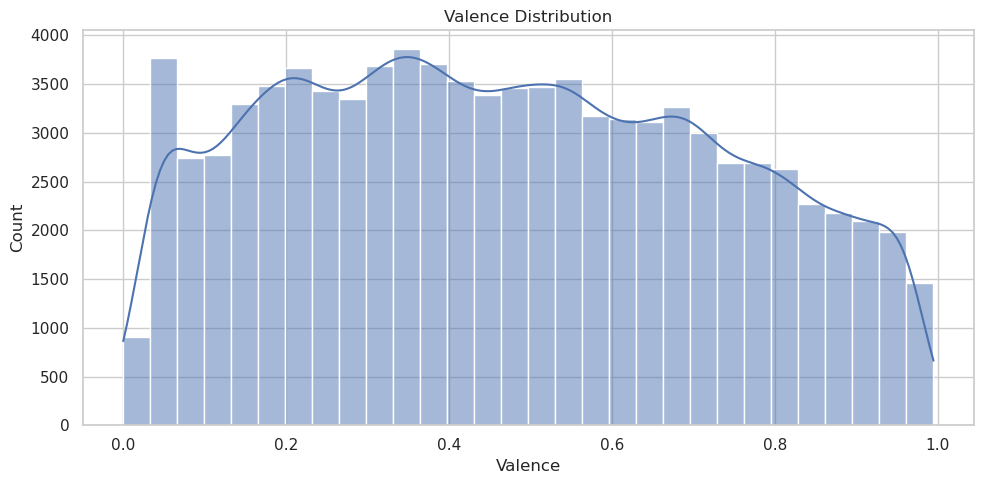

*Figure: Valence (musical positivity) is broadly distributed across the 0–1 range, with slightly more mass in mid values.*

In [26]:
show_fig("dance_distribution.png", "Danceability is approximately unimodal, with many tracks concentrated around mid-to-high values.")
show_fig("energy_distribution.png", "Energy skews high: many tracks in the cleaned sample have relatively high energy.")
show_fig("loudness_distribution.png", "Loudness (dB) is concentrated around a typical modern loudness range with a long left tail to very quiet tracks.")
show_fig("acoustic_distribution.png", "Acousticness shows strong concentration near 0 (non-acoustic tracks), with a secondary mass toward higher acousticness.")
show_fig("speech_distribution.png", "Speechiness is strongly right-skewed, with most tracks near 0 and a small fraction with high speech content.")
show_fig("tempo_distribution.png", "Tempo is multi-modal, with common tempos around typical pop/rock ranges and additional smaller modes at higher tempos.")
show_fig("valence_distribution.png", "Valence (musical positivity) is broadly distributed across the 0–1 range, with slightly more mass in mid values.")


## 4. Correlation structure
To understand which variables move together—and to anticipate multicollinearity in regression—we examine the correlation matrix exported from our analysis pipeline.

In [27]:
# Load correlation matrix (exported by the analysis notebooks)
corr = pd.read_csv(RES_DIR / "full_correlation_matrix.csv", index_col=0)
# Ensure numeric where possible
corr = corr.apply(pd.to_numeric, errors="coerce")
display(corr.iloc[:6, :6])


,popularity,duration_ms,explicit,danceability,energy,key
popularity,1.000000,-0.023119,NaN,0.064281,0.013728,0.003432
duration_ms,-0.023119,1.000000,NaN,-0.064130,0.063261,0.011286
explicit,NaN,NaN,NaN,NaN,NaN,NaN
danceability,0.064281,-0.064130,NaN,1.000000,0.143914,0.035114
energy,0.013728,0.063261,NaN,0.143914,1.000000,0.046334
key,0.003432,0.011286,NaN,0.035114,0.046334,1.000000


In [28]:
# Computed highlights (lightweight summaries)
pop_corr = corr["popularity"].drop(labels=["popularity"]).dropna().sort_values(key=lambda s: s.abs(), ascending=False)
display(pop_corr.head(10).to_frame(name="corr_with_popularity"))

# Top absolute correlations among features (excluding popularity and the engineered duplicate duration columns)
cols = corr.columns.tolist()
pairs = []
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        a, b = cols[i], cols[j]
        r = corr.loc[a, b]
        if pd.isna(r):
            continue
        if a == "popularity" or b == "popularity":
            continue
        if set([a, b]) == set(["duration_ms", "duration_min"]):
            continue
        pairs.append((abs(float(r)), float(r), a, b))

top_pairs = (pd.DataFrame(sorted(pairs, reverse=True)[:10], columns=["abs_r", "r", "feature_1", "feature_2"]))
display(top_pairs)


,corr_with_popularity
instrumentalness,-0.127465
loudness,0.071676
danceability,0.064281
speechiness,-0.047081
acousticness,-0.038847
time_signature,0.036893
duration_min,-0.023119
duration_ms,-0.023119
mode,-0.016214
liveness,-0.013844


,abs_r,r,feature_1,feature_2
0,0.758774,0.758774,energy,loudness
1,0.732566,-0.732566,energy,acousticness
2,0.582663,-0.582663,loudness,acousticness
3,0.492571,0.492571,danceability,valence
4,0.434717,-0.434717,loudness,instrumentalness
5,0.330759,-0.330759,instrumentalness,valence
6,0.289091,0.289091,loudness,valence
7,0.271839,0.271839,danceability,loudness
8,0.258628,0.258628,energy,tempo
9,0.256313,0.256313,energy,valence


### Strongest feature–feature correlations (by absolute value)
Excluding the engineered duplicate (`duration_ms` vs `duration_min`), the strongest relationships are:

- energy vs loudness: r = +0.759
- energy vs acousticness: r = -0.733
- loudness vs acousticness: r = -0.583
- danceability vs valence: r = +0.493
- loudness vs instrumentalness: r = -0.435

These patterns are consistent with musical intuition: tracks with higher energy tend to be louder, and more acoustic tracks tend to have lower energy and loudness.


### Correlations with popularity
Correlations between individual audio features and popularity are generally small in magnitude:

- instrumentalness: r = -0.127
- loudness: r = +0.072
- danceability: r = +0.064
- speechiness: r = -0.047
- acousticness: r = -0.039

The largest (in absolute value) is instrumentalness (negative), suggesting that tracks with more instrumental content tend to be less popular on average in this sample. However, the overall weakness of these correlations signals that linear prediction from audio features alone may be challenging.


## 5. Predictive modeling
We fit a multiple linear regression model to predict popularity from audio features, and compare it to two standard regularized variants:

- Ridge regression (L2 penalty)
- LASSO regression (L1 penalty)

Model fitting, splitting, and cross-validation are performed in separate notebooks; here we only load the exported results. We use RMSE (root mean squared error) on the same 0–100 popularity scale for evaluation [@scikit_learn].


In [29]:
mlr_models = load_csv("mlr_models_comparison.csv")
mlr_models = mlr_models.drop(columns=[c for c in mlr_models.columns if c.startswith("Unnamed")], errors="ignore")
display(mlr_models)


,Model,Train RMSE,Test RMSE,CV Error
0,Multiple Linear Reg,20.278961,20.032047,20.031338
1,+ Ridge,20.278963,20.031911,20.030885
2,+ LASSO,20.278982,20.032112,20.031258


Across these linear approaches, performance is extremely similar. The best (by test RMSE) is + Ridge, with test RMSE = 20.03 (CV error ≈ 20.03).  
An RMSE near 20 means that—on average—the model’s predictions deviate from true popularity by about 20 points, which is sizable relative to the full 0–100 range.


## 6. Multicollinearity diagnostics (VIF)
Because regression coefficient interpretation can be unstable when predictors are highly collinear, we compute Variance Inflation Factors (VIF) for the regression predictors. A common rule of thumb is that VIF values above ~5 (or 10) indicate concerning multicollinearity.


In [30]:
vif = load_csv("regression_vif.csv")
vif = vif.drop(columns=[c for c in vif.columns if c.startswith("Unnamed")], errors="ignore")
# Present predictors (excluding intercept) in descending VIF
display(vif.sort_values("VIF", ascending=False))


,feature,VIF
0,const,170.662614
2,energy,4.261457
4,loudness,3.269276
7,acousticness,2.417361
10,valence,1.600743
1,danceability,1.565985
8,instrumentalness,1.470513
9,liveness,1.158525
6,speechiness,1.146349
11,tempo,1.096353


Excluding the intercept term, the largest VIF values are:

- energy: VIF = 4.26
- loudness: VIF = 3.27
- acousticness: VIF = 2.42

All are below 5, indicating moderate but not severe multicollinearity. The elevated VIFs for energy and loudness align with the strong pairwise correlations observed earlier.


## 7. Discussion
Our results highlight both what audio-feature modeling can and cannot do:

- Audio features alone explain limited variation in Spotify popularity. The weak correlations with popularity and RMSE ≈ 20 suggest that platform-level and social factors likely dominate.
- Collinearity is present but manageable for linear modeling in this feature set (VIF < 5), especially if our goal is prediction rather than fine-grained causal interpretation.
- Popularity is a proprietary metric. Spotify’s popularity score is not a direct measure of “cultural impact” and may reflect platform-specific dynamics such as playlisting, recency effects, and algorithmic exposure.

### Limitations and future work
- Incorporate nonlinear models (e.g., random forests, gradient boosting/XGBoost) and compare performance and feature importance.
- Add time-aware evaluation (e.g., train on earlier years, test on later years) to study how relationships shift across musical eras.
- Include additional predictors (artist-level popularity, release year, genre) if available and allowed by the project scope.


## 8. Conclusion
- Popularity in this dataset is widely dispersed (mean ≈ 33, median ≈ 35), with many tracks at low popularity.
- Several audio features are strongly related to each other (energy–loudness, energy–acousticness), but individual correlations with popularity are weak.
- Linear models provide a clear baseline but achieve only moderate predictive accuracy (test RMSE ≈ 20), implying that much of popularity is not captured by audio descriptors alone.


## 9. Author Contributions
Collin:


Becca:


Jacky:
main.ipynb


Christy: 
02_linear_regression.ipynb skeleton
Myst website



## References
```{bibliography} references.bib
```
